In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile, Aer, execute, IBMQ
from qiskit.extensions import Initialize
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

statevector_sim = Aer.get_backend('statevector_simulator')

# The Quantum Teleportation Circuit

![Quantum Teleportation Circuit](teleportation-circuit.png)


I will define a quantum circuit that has 3 qubits, divided into two quantum registers:
* `alice` - a two-qubit register, the first being the qubit she wants to teleport and the second being her half of the entangled pair
* `bob` - a one-qubit register that initially has Bob's half of the entangled pair. The state of Alice's qubit will be teleported to this qubit.

And three classical bits to hold the measurement:
* `c0` - holds the measurement of `alice[0]`
* `c1` - holds the measurement of `alice[1]`
* `c2` - holds the measurement of `bob` for when we do qubit state tomography later.

In [2]:
alice = QuantumRegister(2,name='alice')
bob = QuantumRegister(1,name='bob')
c0 = ClassicalRegister(1,name='c0')
c1 = ClassicalRegister(1,name='c1')

c2 = ClassicalRegister(1,name='c2')

I'll divide each step of the protocol into different functions:

In [3]:
# Generate entanglement
def makeBellState(qc, alice, bob):
    qc.h(alice[1])
    qc.cx(alice[1],bob)

# Alice's Gates
def aliceGates(qc, alice):
    qc.cx(alice[0], alice[1])
    qc.h(alice[0])

# Alice's Measurements
def aliceMeas(qc, alice, c0, c1):
    qc.measure(alice[0], c0)
    qc.measure(alice[1], c1)

# Bob's corrective gates
def bobGates(qc, bob, c0, c1):
    qc.x(bob).c_if(c1,1)
    qc.z(bob).c_if(c0,1)
    

The following function will initialize `alice[0]` to the single qubit state vector passed through `init` and then create the teleportation circuit.

In [4]:
def simTeleport(qc, alice, bob, c0, c1, c2, init):
    makeBellState(qc, alice, bob)
    qc.barrier()
    
    init_gate = Initialize( init )
    qc.append(init_gate,[alice[0]])
    qc.barrier()
    
    aliceGates(qc, alice)
    qc.barrier()
    
    aliceMeas(qc, alice, c0,c1)
    qc.barrier()
    
    bobGates(qc, bob, c0,c1)
    qc.barrier()

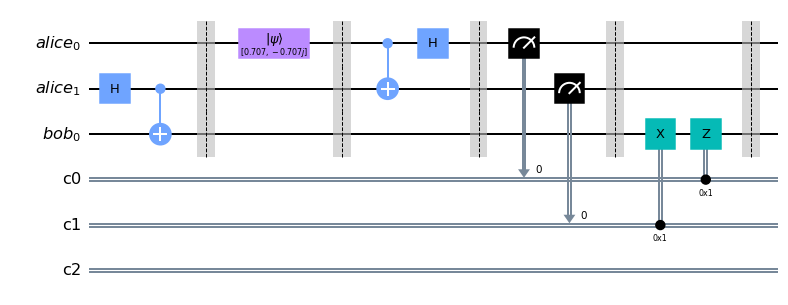

In [5]:
# Set psi to any unit-norm 2-d vector to pass as the initial qubit state to be teleported
psi = [np.sqrt(0.5), -np.sqrt(0.5)*1j] # setting |psi> = (|0> - i|1>) / sqrt(2)
qc = QuantumCircuit(alice,bob, c0,c1, c2)
simTeleport(qc, alice, bob, c0, c1, c2, psi)
qc.draw()

Now, testing this circuit on the Statevector Simulator to see that the state is indeed being copied.

The statevector simulator calculates the statevector of **every qubit** in the circuit in exactly one run. 
At the end of the run, the state of the system should be 
$$ |c_0\rangle\otimes|c_1\rangle\otimes|\psi\rangle$$
which will be one of four different statevectors depending on the measured `c0` and `c1`.


In [6]:
t_qc = transpile(qc, statevector_sim)
result = execute(t_qc, statevector_sim).result()
final_state = result.get_statevector()
counts = result.get_counts()

display(array_to_latex(np.array(psi), prefix=r'|\psi\rangle = '))
display(array_to_latex(final_state, prefix=r'\text{Final State} = '))
print('')

meas = list(counts.keys())[0]
_c0 = int(meas[-1])
_c1 = int(meas[-3])

print('c0 =',_c0, ',\tc1 =',_c1)

# Verify that the state was copied
q1q0 = np.kron( [1.0 if _c1==0 else 0.0, 1.0 if _c1==1 else 0.0 ], [1.0 if _c0==0 else 0.0, 1.0 if _c0==1 else 0.0 ] )

display(array_to_latex(np.kron(np.array(psi),q1q0), prefix=r'\text{Expected Final State}='))
state_copied = np.linalg.norm(np.array(final_state) - np.kron(psi, q1q0)) < 1e-3

if state_copied:
    print('The state was successfully teleported')
else:
    print('The state was not teleported')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


c0 = 1 ,	c1 = 1


<IPython.core.display.Latex object>

The state was successfully teleported


# Running on actual Quantum Computers

Unfortunately, IBM's quantum computers don't support clasically controlled operations as of yet. We can't use the above circuit to do teleportation. We can however make use of the _principle of deferred measurement_ to emulate the teleportation protocol.

The principle says that we can replace the measurement followed by a classically controlled gate with a quantum controlled gate followed by a measurement without affecting the computation.

Making use of this, we alter the protocol steps:

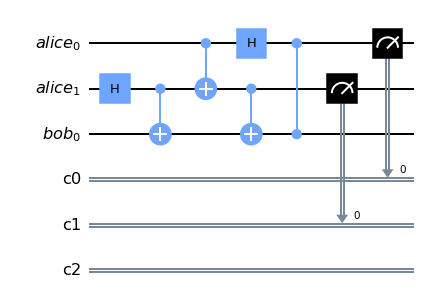

In [7]:
def deferredBob(qc, alice, bob, c0,c1):
    qc.cx(alice[1],bob)
    qc.cz(alice[0],bob)
    
    qc.measure(alice[0], c0)
    qc.measure(alice[1], c1)

def realTeleport(qc, alice, bob, c0, c1):
    makeBellState(qc, alice, bob)
    aliceGates(qc, alice)
    deferredBob(qc, alice, bob, c0, c1)

teleport_circ = QuantumCircuit(alice,bob, c0,c1,c2, name='Teleportation Circuit')
realTeleport(teleport_circ, alice,bob, c0,c1)
teleport_circ.draw()

Verifying that this circuit also "teleports" the qubit state to Bob

In [8]:
qc = QuantumCircuit(alice,bob, c0,c1,c2)
qc.append(Initialize(psi),[alice[0]])
qc.append(teleport_circ, [alice[0],alice[1],bob], [c0,c1,c2])

t_qc = transpile(qc, statevector_sim)
result = execute(t_qc, statevector_sim).result()
final_state = result.get_statevector()
counts = result.get_counts()

display(array_to_latex(np.array(psi), prefix=r'|\psi\rangle = '))
display(array_to_latex(final_state, prefix=r'\text{Final State} = '))
print('')

meas = list(counts.keys())[0]
_c0 = int(meas[-1])
_c1 = int(meas[-3])

print('c0 =',_c0, ',\tc1 =',_c1)

# Verify that the state was copied
q1q0 = np.kron( [1.0 if _c1==0 else 0.0, 1.0 if _c1==1 else 0.0 ], [1.0 if _c0==0 else 0.0, 1.0 if _c0==1 else 0.0 ] )

display(array_to_latex(np.kron(np.array(psi),q1q0), prefix=r'\text{Expected Final State}='))
state_copied = np.linalg.norm(np.array(final_state) - np.kron(psi, q1q0)) < 1e-3

if state_copied:
    print('The state was successfully teleported')
else:
    print('The state was not teleported')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


c0 = 1 ,	c1 = 0


<IPython.core.display.Latex object>

The state was successfully teleported


# Quantum State Tomography
Using the statevector simulator, we are able to verify that the circuit works properly in a noiseless environment. However, on actual quantum hardware, we are unable to observe the state of the system. So, to try and verify the state of Bob's qubit at the end of the protocol, I will use quantum state tomography.

We will run multiple runs of the protocol and measure Bob's qubit in the X, Y and Z bases. Taking the mean of the measured eigenvalues for each of these measurements gives us $(\bar{n}_x, \bar{n}_y, \bar{n}_z)$, a Bloch vector corresponding to the density matrix
$$ \rho = \frac{1}{2} (I + \bar{n}_x X + \bar{n}_y Y + \bar{n}_z Z ) $$

In a noiseless environment, the measured Bloch vector tends to the Bloch vector of the initial state $|\psi\rangle$ as we increase the number of measurements we take. With noise present, as on an actual quantum computer, there will be fluctuations in the measurement statistics. The density matrix will correspond to a mixed state and we can use it to calculate the fidelity of Bob's qubit state compared to $|\psi\rangle$ when running the protocol on the hardare.
$$ F = \sqrt{\langle\psi|\rho|\psi\rangle} $$

In [9]:
# Circuits to measure in the X, Y and Z bases
def x_meas(qc, q, c):
    qc.h(q)
    qc.measure(q,c)

def y_meas(qc, q, c):
    qc.sdg(q)
    qc.h(q)
    qc.measure(q,c)

def z_meas(qc, q, c):
    qc.measure(q, c)

# Given an initial state, a circuit that generates the initial state and the teleportation circuit
# return the circuits to obtain the X,Y and Z measurements for tomography
def getCircuits(init_state, init_circ, teleport_circ):
    x_circ = QuantumCircuit(alice,bob, c0,c1,c2)
    
    if init_circ == None:
        init_circ = Initialize(init_state)
    
    x_circ.append(init_circ, [alice[0]])
    x_circ.append(teleport_circ, [alice[0],alice[1],bob],[c0,c1,c2])
    
    y_circ = x_circ.copy()
    z_circ = x_circ.copy()
    
    x_meas(x_circ, bob, c2)
    y_meas(y_circ, bob, c2)
    z_meas(z_circ, bob, c2)
    
    return x_circ,y_circ,z_circ

# Run the jobs on the backend
def runJobs(teleport_circ, init_state, init_circ, backend, num_shots, optimization_level):
    x_circ, y_circ, z_circ = getCircuits(init_state, init_circ, teleport_circ)
    
    t_xc = transpile(x_circ, backend, optimization_level=optimization_level)
    t_yc = transpile(y_circ, backend, optimization_level=optimization_level)
    t_zc = transpile(z_circ, backend, optimization_level=optimization_level)
    
    xResult = backend.run(t_xc, shots=num_shots).result()
    yResult = backend.run(t_yc, shots=num_shots).result()
    zResult = backend.run(t_zc, shots=num_shots).result()
    
    return xResult, yResult, zResult

# Calculate the Bloch vector coordinate from the measurement statistics
def calcExpectation(counts):
    mean = 0
    num_shots = 0
    for k in counts.keys():
        if k[0] == '0':
            mean += counts[k]
            num_shots += counts[k]
        else:
            mean -= counts[k]
            num_shots += counts[k]
    mean /= num_shots
    return mean

def stateToBloch(init):
    psi = np.array(init, dtype=complex)
    theta = np.arccos(psi[0])
    phase = psi[1]/np.sin(theta)
    
    theta = theta * 2.0
    phi = np.real(-1.0j * np.log(phase))
    
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

# The Pauli Matrices
sigma_x = np.array([[0.0, 1.0],   [1.0, 0.0]], dtype=complex)
sigma_y = np.array([[0.0, -1.0j], [1.0j, 0.0]], dtype=complex)
sigma_z = np.array([[1.0, 0.0],   [0.0, -1.0]], dtype=complex)

# Display the density matrix and calculate the fidelity
def fidelity(x,y,z, init_state):
    psi = np.array([ [init_state[0]], [init_state[1]] ], dtype=complex)
    rho = 0.5*(np.identity(2) + x*sigma_x + y*sigma_y + z*sigma_z)
    
    f = np.real(np.sqrt(psi.transpose().conj() @ rho @ psi))[0][0]
    
    return f, rho

# Analyze the results of the job
def analyzeResults(xResult, yResult, zResult, init_state, print_flag=True):
    x_counts = xResult.get_counts()
    y_counts = yResult.get_counts()
    z_counts = zResult.get_counts()
    
    mean_x = calcExpectation(x_counts)
    mean_y = calcExpectation(y_counts)
    mean_z = calcExpectation(z_counts)
    ex = np.array([mean_x, mean_y, mean_z])
    bloch = stateToBloch(init_state)
    angle = np.arccos(np.real(np.dot(ex, bloch)/np.linalg.norm(ex)))
    f,rho = fidelity(mean_x, mean_y, mean_z, init_state)
    
    if print_flag:
        display(array_to_latex(init_state, prefix=r'|\psi\rangle = '))
        display(array_to_latex(bloch, prefix=r'\text{Bloch vector of } |\psi\rangle = '))

        print('Expectation of X measurements:', mean_x)
        print('Expectation of Y measurements:', mean_y)
        print('Expectation of Z measurements:', mean_z)
        display(array_to_latex(rho, prefix=r"\rho = "))

        print(r'Angle between Bloch vector of |psi> and rho =', angle, 'radians')

        print("Fideility =", f)
    
    analysis = {
        'init_state': init_state,
        'mean_x': mean_x,
        'mean_y': mean_y,
        'mean_z': mean_z,
        'angle': angle,
        'fidelity': f,
    }
    
    return analysis
    

In [10]:
backend = provider.get_backend('ibmq_5_yorktown')
backend

<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>

# Running the Protocol on Different Input States

First I'll run the protocol on a random qubit state testing the fidelity at all of the optimization levels on the backend (0-3). 

## Random Qubit State
Any single-qubit state can be parameterized by parameterized by two angles $0\leq \theta \leq \pi$ and $0 \leq \varphi < 2\pi$:
$$ |\psi\rangle = \cos\frac{\theta}{2} |0\rangle + e^{i\varphi}\sin\frac{\theta}{2}|1\rangle $$

In [11]:
def getRandomState():
    theta = np.random.uniform(0,np.pi)
    phi = np.random.uniform(0,2.0*np.pi)
    state = np.array([ np.cos(theta/2.0), np.exp(phi*1.0j) * np.sin(theta/2.0) ])
    return state

init_state = getRandomState()
init_circ = None

## Testing the Fidelity at different optimization levels

In [12]:
# Store the analysis data of the jobs in these arrays
analyses_0 = []
analyses_1 = []
analyses_2 = []
analyses_3 = []

In [28]:
xResult, yResult, zResult = runJobs(teleport_circ, init_state, init_circ, backend, backend.configuration().max_shots, 0)
analyses_0.append(analyzeResults(xResult, yResult, zResult, init_state))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Expectation of X measurements: 0.01416015625
Expectation of Y measurements: 0.084228515625
Expectation of Z measurements: 0.60205078125


<IPython.core.display.Latex object>

Angle between Bloch vector of |psi> and rho = 0.026992808381347964 radians
Fideility = 0.8966207414355939


In [29]:
xResult, yResult, zResult = runJobs(teleport_circ, init_state, init_circ, backend, backend.configuration().max_shots, 1)
analyses_1.append(analyzeResults(xResult, yResult, zResult, init_state))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Expectation of X measurements: -0.074462890625
Expectation of Y measurements: 0.1943359375
Expectation of Z measurements: 0.728515625


<IPython.core.display.Latex object>

Angle between Bloch vector of |psi> and rho = 0.14791680036445579 radians
Fideility = 0.9352499442607628


In [30]:
xResult, yResult, zResult = runJobs(teleport_circ, init_state, init_circ, backend, backend.configuration().max_shots, 2)
analyses_2.append(analyzeResults(xResult, yResult, zResult, init_state))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Expectation of X measurements: -0.106689453125
Expectation of Y measurements: 0.203857421875
Expectation of Z measurements: 0.732421875


<IPython.core.display.Latex object>

Angle between Bloch vector of |psi> and rho = 0.18686266299670415 radians
Fideility = 0.9365756704615776


In [31]:
xResult, yResult, zResult = runJobs(teleport_circ, init_state, init_circ, backend, backend.configuration().max_shots, 3)
analyses_3.append(analyzeResults(xResult, yResult, zResult, init_state))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Expectation of X measurements: -0.116943359375
Expectation of Y measurements: 0.1728515625
Expectation of Z measurements: 0.748046875


<IPython.core.display.Latex object>

Angle between Bloch vector of |psi> and rho = 0.17650034497608383 radians
Fideility = 0.9392943009319036


In [15]:
# Write to csv files
import csv

Now I'll run multiple analyses at different optimization levels choosing a new random state each time to see which optimization level gives the highest average fidelity over multiple states

In [34]:
num_trials = 50
num_shots = 1000
for i in range(num_trials):
    init_state = getRandomState()
    
    xResult, yResult, zResult = runJobs(teleport_circ, init_state, init_circ, backend, num_shots, 0)
    analyses_0.append(analyzeResults(xResult, yResult, zResult, init_state, False))
    
    xResult, yResult, zResult = runJobs(teleport_circ, init_state, init_circ, backend, num_shots, 1)
    analyses_1.append(analyzeResults(xResult, yResult, zResult, init_state, False))
    
    xResult, yResult, zResult = runJobs(teleport_circ, init_state, init_circ, backend, num_shots, 2)
    analyses_2.append(analyzeResults(xResult, yResult, zResult, init_state, False))
    
    xResult, yResult, zResult = runJobs(teleport_circ, init_state, init_circ, backend, num_shots, 3)
    analyses_3.append(analyzeResults(xResult, yResult, zResult, init_state, False))

with open('opt_jobs_0.csv','w',newline='') as file0:
    dict_writer = csv.DictWriter(file0, keys)
    dict_writer.writeheader()
    dict_writer.writerows(analyses_0)
    
with open('opt_jobs_1.csv','w',newline='') as file1:
    dict_writer = csv.DictWriter(file1, keys)
    dict_writer.writeheader()
    dict_writer.writerows(analyses_1)
    
with open('opt_jobs_2.csv','w',newline='') as file2:
    dict_writer = csv.DictWriter(file2, keys)
    dict_writer.writeheader()
    dict_writer.writerows(analyses_2)
    
with open('opt_jobs_3.csv','w',newline='') as file3:
    dict_writer = csv.DictWriter(file3, keys)
    dict_writer.writeheader()
    dict_writer.writerows(analyses_3)

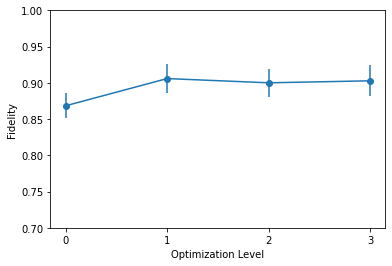

In [16]:
with open('opt_jobs_0.csv') as f:
    fid_0 = np.array([float(row['fidelity']) for row in csv.DictReader(f)])

with open('opt_jobs_1.csv') as f:
    fid_1 = np.array([float(row['fidelity']) for row in csv.DictReader(f)])
    
with open('opt_jobs_2.csv') as f:
    fid_2 = np.array([float(row['fidelity']) for row in csv.DictReader(f)])
    
with open('opt_jobs_3.csv') as f:
    fid_3 = np.array([float(row['fidelity']) for row in csv.DictReader(f)])

means = [np.mean(fid_0), np.mean(fid_1), np.mean(fid_2), np.mean(fid_3)]
std_devs = [np.std(fid_0), np.std(fid_1), np.std(fid_2), np.std(fid_3)]

import matplotlib.pyplot as plt

fig = plt.figure()
#plt.title('Fidelity of Teleportation Protocol on ibmq_5_yorktown at Different Circuit Optimization Levels')
plt.xlabel('Optimization Level')
plt.ylabel('Fidelity')
plt.ylim(0.7, 1.0)
plt.xticks(range(4))

x = [0,1,2,3]
plt.errorbar(x,means,yerr=std_devs,marker='o')

plt.savefig('fidelity-vs-optimization-level.png')

fig.show()